# 1. Setup

In [1]:
import sys
sys.path.append('../..')
import mobiquity as mq
from mobiquity.names import *

In [2]:
state_codes = U.load(DATA / 'us_states.csv').disp()

49 rows x 3 cols; Memory: 0.0 MiB


,name,code,fips
,<object>,<object>,<int64>
0,Alabama,AL,1


In [3]:
zonesIN = U.load(DATA / 'zones/in_2020.parquet').disp(0)

7,078 rows x 9 cols; Memory: 1.0 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,county,urba,top_msa,msa,aland,awater,geometry
,<object>,<category>,<category>,<category>,<bool>,<category>,<float32>,<float32>,<geometry>


# 2. ACS

## 2.1. Explore fields

### 2.1.1. Download fields

In [4]:
cols21 = mq.ses.get_acs_fields(2021).disp()
cols21.to_csv(DATA / 'ses/acs/fields_2021.csv')

13,682 rows x 4 cols; Memory: 5.8 MiB


,fname,tname,tid,fnum
fid,<object>,<object>,<object>,<object>
B01001_001E,total,sex by age,B01001,001


### 2.1.2. Create field tree
Write a YAML file from the indents of the columns.
This may not always work since the input data indent structure could be flawed (e.g., in table B02016).

In [5]:
path = DATA / 'ses/acs/field_tree_2021.yaml'
mq.ses.make_acs_field_tree(cols21, path)

## 2.2. Download data
The relevant fields were selected using the field tree, combined with the `cols21` table, and exported to the file `{DATA}/imp_acs_fields.csv`.

In [6]:
acs_cols = U.load(DATA / 'imp_acs_fields.csv').disp()

91 rows x 3 cols; Memory: 0.0 MiB


,field_id,title,table
,<object>,<object>,<object>
0,B01001_001E,total,sex by age


In [7]:
with open('../../.env', 'r') as f:
    lines = f.readlines()
lines = [x.split('=')[1].strip('\n') for x in lines
         if x.split('=')[0] == 'acs_key']
acs_key = lines[0] if len(lines) > 0 else None

In [8]:
def download_acs(year, cols=list(acs_cols.field_id),
                 states=list(state_codes.fips), key=acs_key, overwrite=False):
    outpath = DATA / f'ses/acs/raw_{year}.parquet'
    if (df := U.checkfile(outpath, overwrite)) is not None: return df
    acs = mq.ses.get_acs_data(year, cols, state_codes=states, key=key)
    acs.to_parquet(U.mkfile(outpath))
    return acs

# acs_raw19 = download_acs(2019).disp() # 5m15s
acs_raw21 = download_acs(2021).disp() # 4m53s

238,193 rows x 92 cols; Memory: 181.0 MiB


,geoid,B01001_001E,B02001_002E,B02001_003E,B06001_002E,B08301_001E,B08301_010E,B08301_018E,B08301_019E,B08301_021E,...,B25033_013E,B25044_001E,B25044_003E,B25044_010E,B25046_001E,B27010_001E,B27010_017E,B27010_033E,B27010_050E,B27010_066E
,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,...,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,010010201001,693.0,606.0,16.0,NaN,308.0,0.0,0.0,0.0,0.0,...,0.0,252.0,0.0,0.0,581.0,693.0,0.0,85.0,27.0,0.0


## 2.3. Prepare data

| Variable      | Category      | Description                               | Extensive?    |
| ---------     | ------------- | ----------------------------------------- | ------------- |
| `popu`        | Demographics  | Total population                          | Yes           |
|`house`        | Housing       | Total housing units | Yes |
|`labor`        | Economy       | Size of labor force (population aged ≥16 y) | Yes |
|`pop_density`  | Demographics  | Population per square mile | No |
|`house_densiy` | Housing       | No. of housing units per square mile | No |
|`p_minor`      | Demographics  | Proportion of popu aged ≤18 y | No |
|`p_poc`        | Demographics  | Proportion of people of color (non-White) | No |
|`p_loweng`     | Demographics  | Proportion of population in limited English-speaking households | No |
|`m_income`     | Economy       | Per capita income in the last year, measured as the complement of the normalized log of  inflation-adjusted value in USD | No |
|`p_pov`        | Economy       | Proportion of eligible population below poverty level | No |
|`p_snap`       | Economy       | Proportion of households having received food stamps/SNAP last year | No |
|`p_unemploy`   | Economy       | Proportion of labor force unemployed | No |
|`p_lowedu`     | Demographics  | Proportion people above 25 years with highest degree high shcool or lesser | No |
|`p_noinsur`    | Economy       | Proportion of population without health insurance coverage | No |
|`p_disabled`   | Demographics  | Proportion of eligible population with a disability | No |
|`p_snglparent` | Family        | Proportion of households with children that are led by single parents | No |
|`p_crowded`    | Family        | Proportion of households that are crowded (>1.01 persons per room) | No |
|`p_renter`     | Economy       | Proportion of housing units occupied by renters | No |
|`p_mobilehome` | Housing       | Proportion of occupied housing units that are mobile homes | No |
|`p_noveh`      | Transport     | Proportion of households not owning any vehicle | No |
|`m_hhperveh`   | Transport     | Mean no. of households per vehicle | No |
|`p_nowfh`      | Transport     | Proportion of workers who do not (or cannot) work from home | No |
|`p_transit`    | Transport     | Proportion of commuting workers using public transit | No |
|`p_walkbike`   | Transport     | Proportion of commuting workers who commute by walking or bicylcing | No |

In [9]:
def get_acs(year, overwrite=False):
    outpath = DATA / f'ses/acs/acs_{year}.parquet'
    if (df := U.checkfile(outpath, overwrite)) is not None: return df
    acs = pd.read_parquet(DATA / f'ses/acs/raw_{year}.parquet')
    res = []
    for scale, nchar in D(County=5, Tract=11, BG=12).items():
        df = acs.assign(geoid=acs['geoid'].str[:nchar])
        df = df.groupby('geoid').sum()
        df = Pdf(D(
            ## Extensive variables
            popu = df.B01001_001E,
            house = df.B25033_001E,
            labor = df.B23025_002E,
            ## Demographics
            p_minor = df.B16004_002E / df.B01001_001E,
            # p_senior = df.B16004_046E / df.B01001_001E,
            p_poc = 1 - df.B02001_002E / df.B01001_001E,
            p_loweng = pd.concat([df[f'B16004_{i:03}E'] for i in (
                7, 8, 12, 13, 17, 18, 22, 23, 29, 30, 34, 35, 39, 40, 44,
                45, 51, 52, 56, 57, 61, 62, 66, 67)], axis=1).sum(1) / df.B16004_001E,
            ## Economic
            m_income = 1 - U.normalize(np.log10(1 + df.B19301_001E.clip(0))),
            p_pov = df.B17021_002E / df.B17021_001E,
            # p_pov150 = (df.B17026_002E + df.B17026_003E + df.B17026_004E + 
            #             df.B17026_005E + df.B17026_006E) / df.B17026_001E,
            p_snap = df.B22010_002E / df.B19001_001E,
            p_unemploy = df.B23025_005E / df.B23025_002E,
            ## Health & Education
            p_lowedu = 1 - (df.B15003_018E + df.B15003_019E + df.B15003_020E + 
                            df.B15003_021E + df.B15003_022E + df.B15003_023E + 
                            df.B15003_024E + df.B15003_025E) / df.B15003_001E,
            p_noinsur = (df.B27010_017E + df.B27010_033E + df.B27010_050E + 
                         df.B27010_066E) / df.B27010_001E,
            p_disabled = (df.B22010_003E + df.B22010_006E) / df.B22010_001E,
            ## House & Family
            p_snglparent = (df.B11012_010E + df.B11012_015E) / (
                df.B11012_003E + df.B11012_006E + df.B11012_010E + df.B11012_015E),
            p_crowded = (df.B25014_005E + df.B25014_006E + df.B25014_007E + 
                         df.B25014_011E + df.B25014_012E + df.B25014_013E) / df.B25014_001E,
            p_renter = df.B25033_008E / df.B25033_001E,
            p_mobilehome = (df.B25033_006E + df.B25033_013E) / df.B25033_001E,
            ## Transport
            p_noveh = (df.B25044_003E + df.B25044_010E) / df.B25044_001E,
            m_hhperveh = df.B25044_001E / df.B25046_001E,
            p_nowfh = 1 - (df.B08301_021E / df.B08301_001E),
            p_transit = df.B08301_010E / (df.B08301_001E - df.B08301_021E),
            p_walkbike = (df.B08301_018E + df.B08301_019E) / (df.B08301_001E - df.B08301_021E),
        )).set_index(df.index)
        df.insert(0, 'scale', scale)
        res.append(df.reset_index().query('popu > 0'))
    df = pd.concat(res).reset_index(drop=1).fillna(0)
    df = df.merge(pd.read_parquet(
        DATA / f'zones/zones_{(year//10)*10}.parquet', columns=['geoid', 'aland']))
    aland = df.pop('aland')
    df.insert(5, 'pop_density', df.popu / (aland + EPS))
    df.insert(6, 'house_density', df.house / (aland + EPS))
    df.to_parquet(U.mkfile(outpath))
    return df

# acs19 = get_acs(2019, overwrite=0).disp() # 4s
acs21 = get_acs(2021, overwrite=0).disp() # 5s

322,202 rows x 26 cols; Memory: 98.5 MiB


,geoid,scale,popu,house,labor,pop_density,house_density,p_minor,p_poc,p_loweng,...,p_disabled,p_snglparent,p_crowded,p_renter,p_mobilehome,p_noveh,m_hhperveh,p_nowfh,p_transit,p_walkbike
,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,...,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,01001,County,58239.0,57692.0,27550.0,97.970679,97.050506,0.18,0.248699,0.002312,...,0.344985,0.231925,0.014733,0.233811,0.111367,0.054081,0.7189,0.952604,0.005713,0.009721


# 3. Combine with other indices

## 3.1. SEDI
SEDI: Socio-Economic Disadvantage Index

In [10]:
def get_setdi(year, cols=(
        'p_pov p_unemploy p_lowedu p_noinsur p_disabled '
        'p_snglparent p_crowded p_renter p_noveh').split()
        # 'p_poc p_pov p_snglparent p_crowded p_lowedu p_renter p_transit p_walkbike '
        # 'p_noveh p_noinsur p_lowenglish p_disabled p_unemploy').split()
):
    ses = U.load(DATA / f'ses/acs/acs_{year}.parquet')
    df = []
    for _, d in ses.groupby('scale'):
        d = d.set_index('geoid')[cols].rank(pct=True)
        d['sedi'] = d.mean(axis=1).rank(pct=True)
        df.append(d)
    df = pd.concat(df).reset_index()
    return df

# sedi19 = get_setdi(2019).disp(0)
sedi21 = get_setdi(2021).disp()

322,202 rows x 11 cols; Memory: 45.7 MiB


,geoid,p_pov,p_unemploy,p_lowedu,p_noinsur,p_disabled,p_snglparent,p_crowded,p_renter,p_noveh,sedi
,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,010010201001,0.730171,0.354624,0.768349,0.837631,0.947798,0.812798,0.271324,0.450962,0.150293,0.696373


## 3.2. SVI

**Social Vulnerability Index (SVI)** downloaded CSV files from https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html at county & tract level. The BG-level data is replicated as the tract-level data for the sake of consistency with data format, esp. for the dashboard.

In [11]:
bg20 = U.load(DATA / 'zones/zones_2020.parquet', geom=False,
              filters=[('scale', '==', 'BG')], columns=['geoid'])

In [12]:
# original SVI data at county and tract level
svi20 = (
    pd.concat([U.load(DATA / f'ses/svi_us_{scale}_2020.csv')
               .assign(scale=scale.title()) for scale in ['county', 'tract']])
    .rename(columns=lambda x: x.lower().replace('rpl_theme', 'svi'))
    .rename(columns=D(fips='geoid', svis='svi')).astype(D(geoid=str))
    ['geoid scale svi svi1 svi2 svi3 svi4'.split()].replace(-999, np.nan))
# broadcast the tract-level data to CBGs
svi20_bg = (
    U.filt(svi20, scale='Tract').rename(columns=D(geoid='tract_id'))
    .merge(bg20.assign(tract_id=lambda df: df.geoid.str[:11])
           [['geoid', 'tract_id']], on='tract_id').assign(scale='BG')
    ['geoid scale svi svi1 svi2 svi3 svi4'.split()])
# combine the data of all the scales
svi20 = (
    pd.concat([svi20, svi20_bg]).reset_index(drop=1)
    .rename(columns=D(svi1='svi_ses', svi2='svi_hh',
                      svi3='svi_race', svi4='svi_trans'))).disp()

281,843 rows x 7 cols; Memory: 45.3 MiB


,geoid,scale,svi,svi_ses,svi_hh,svi_race,svi_trans
,<object>,<object>,<float64>,<float64>,<float64>,<float64>,<float64>
0,1001,County,0.513,0.3838,0.7362,0.6337,0.4309


## 3.3. ADI

**Area Disadvantage Index** downloaded from https://www.neighborhoodatlas.medicine.wisc.edu.

In [13]:
adi = (pd.read_csv(DATA / 'ses/adi_us_bg_2021.csv')
       .rename(columns=str.lower).rename(columns=D(fips='geoid'))
       .query('adi_staternk.str.isdigit() & adi_natrank.str.isdigit()'))
adi['st'] = adi.adi_staternk.astype(float) / 10
adi['nat'] = adi.adi_natrank.astype(float) / 100
adi = adi[['geoid', 'st', 'nat']].astype(D(geoid=str)).assign(scale='BG')
for scale, nChar in D(County=5, Tract=11).items():
    df = adi.assign(geoid=adi.geoid.str[:nChar])
    df = df.groupby('geoid')[['st', 'nat']].mean().reset_index()
    adi = pd.concat([adi, df.assign(scale=scale)])
adi = adi.rename(columns=D(st='adi_st', nat='adi_nat')).disp()

353,798 rows x 4 cols; Memory: 51.4 MiB


,geoid,adi_st,adi_nat,scale
,<object>,<float64>,<float64>,<object>
0,10010201001,0.5,0.77,BG


## 3.4. Combine and export

In [14]:
ses = (acs21.merge(svi20.drop(columns='scale'), 'left', on='geoid')
       .merge(adi[['geoid', 'adi_nat']], 'left', on='geoid')
       .merge(sedi21[['geoid', 'sedi']], 'left', on='geoid')
       .set_index(['geoid', 'scale']).astype(F32).reset_index()).disp()
ses.to_parquet(DATA / 'ses/ses.parquet')

325,010 rows x 33 cols; Memory: 78.2 MiB


,geoid,scale,popu,house,labor,pop_density,house_density,p_minor,p_poc,p_loweng,...,p_nowfh,p_transit,p_walkbike,svi,svi_ses,svi_hh,svi_race,svi_trans,adi_nat,sedi
,<object>,<object>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,...,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
0,01001,County,58239.0,57692.0,27550.0,97.97068,97.050507,0.18,0.248699,0.002312,...,0.952604,0.005713,0.009721,NaN,NaN,NaN,NaN,NaN,NaN,0.385457


# 4. Visualize

## 4.1. US

In [15]:
# cnty_us = U.load(DATA / 'zones/zones_2020.parquet',
#                  columns=['geoid', 'state', 'geometry'],
#                  filters=[('scale', '==', 'County')]).disp(0) # 10s
# state_us = cnty_us.dissolve('state').reset_index() # 18s
# df = cnty_us.merge(U.filt(ses, scale='County')[['geoid', 'sedi']])
# ax = U.plot(size=(10, 5), axoff=1)
# U.maplot(df, 'sedi', ax, cmap='rainbow', label='SEDI', basemap=None)
# state_us.plot(ax=ax, fc='none', ec='k', lw=0.8)
# U.imsave('SEDI values of US') # 6s

## 4.2. Indiana

### 4.2.1. SEDI

In [16]:
# ax = U.plot(size=(6, 12), dpi=150, axoff=1)
# df = U.filt(zonesIN, scale='Tract').merge(sedi21)
# U.maplot(df, 'sedi', ax, cmap='RdYlGn_r', shrink=0.4,
#          label='SEDI', vmin=0, vmax=1, basemap=None, scalebar=0)
# U.filt(zonesIN, scale='County').plot(ax=ax, fc='none', ec='k', lw=1)
# U.imsave('SEDI values of Indiana')

### 4.2.2. SVI

In [17]:
# _, axes = plt.subplots(1, 5, figsize=(30, 12), dpi=150)
# for ax, var in zip(axes, svi20.columns[2:]):
#     ax = U.plot(ax, axoff=1, title=var.upper())
#     U.filt(zonesIN, scale='Tract').merge(svi20).plot(
#         var, ax=ax, cmap='RdYlGn_r', legend=True,
#         legend_kwds=D(shrink=0.4, label='SVI'))
#     U.filt(zonesIN, scale='County').plot(ax=ax, fc='none', ec='k', lw=1)
# plt.subplots_adjust(wspace=-0.05)
# U.imsave('SVI by theme in Indiana') # 7s

### 4.2.3. ADI

In [18]:
# _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12), dpi=150)
# for ax, var, label in [(ax1, 'adi_nat', 'National ADI %ile'),
#                        (ax2, 'adi_st', 'State ADI decile')]:
#     ax = U.plot(ax, axoff=1, title=label)
#     df = U.filt(zonesIN, scale='BG').merge(adi)
#     U.maplot(df, var, ax, cmap='RdYlGn_r', shrink=0.4,
#              label='Normalized value', basemap=None)
#     U.filt(zonesIN, scale='County').plot(ax=ax, fc='none', ec='k', lw=1)
# plt.subplots_adjust(wspace=-0.05)
# U.imsave('ADI national and state values for Indiana') # 4s

## 4.3. Correlation

### 4.3.1. Correlation of SES variables

In [19]:
def plot_corr_matrix(ses, state_fips=None):
    if state_fips:
        ses = ses[ses.geoid.str[:2] == str(state_fips)]
    df = ses.set_index('scale').rename(columns=str.upper).iloc[:, 1:]
    corr = (np.triu(df.loc['County', :].corr(), 1) +
            np.tril(df.loc['Tract', :].corr(), -1))
    corr = Pdf(corr, index=df.columns, columns=df.columns)
    np.fill_diagonal(corr.values, np.nan)
    ax = U.plot(size=(14, 15), dpi=200)
    sns.heatmap(corr, square=True, ax=ax,
                cmap='seismic', vmax=.8, vmin=-.8,
                annot=True, fmt='.2f', annot_kws=D(fontsize=7.5),
                cbar_kws=D(shrink=0.4, orientation='horizontal',
                           label='Pearson correlation'))
    ax.invert_xaxis(); ax.grid(alpha=0); ax.minorticks_off()
    ax = U.plot(ax, xlab='Tract', ylab='County')
    title = 'Correlation of SED variables for '
    title += (f'state {state_fips}' if state_fips else 'US')
    U.imsave(title)

# plot_corr_matrix(ses) # 3s

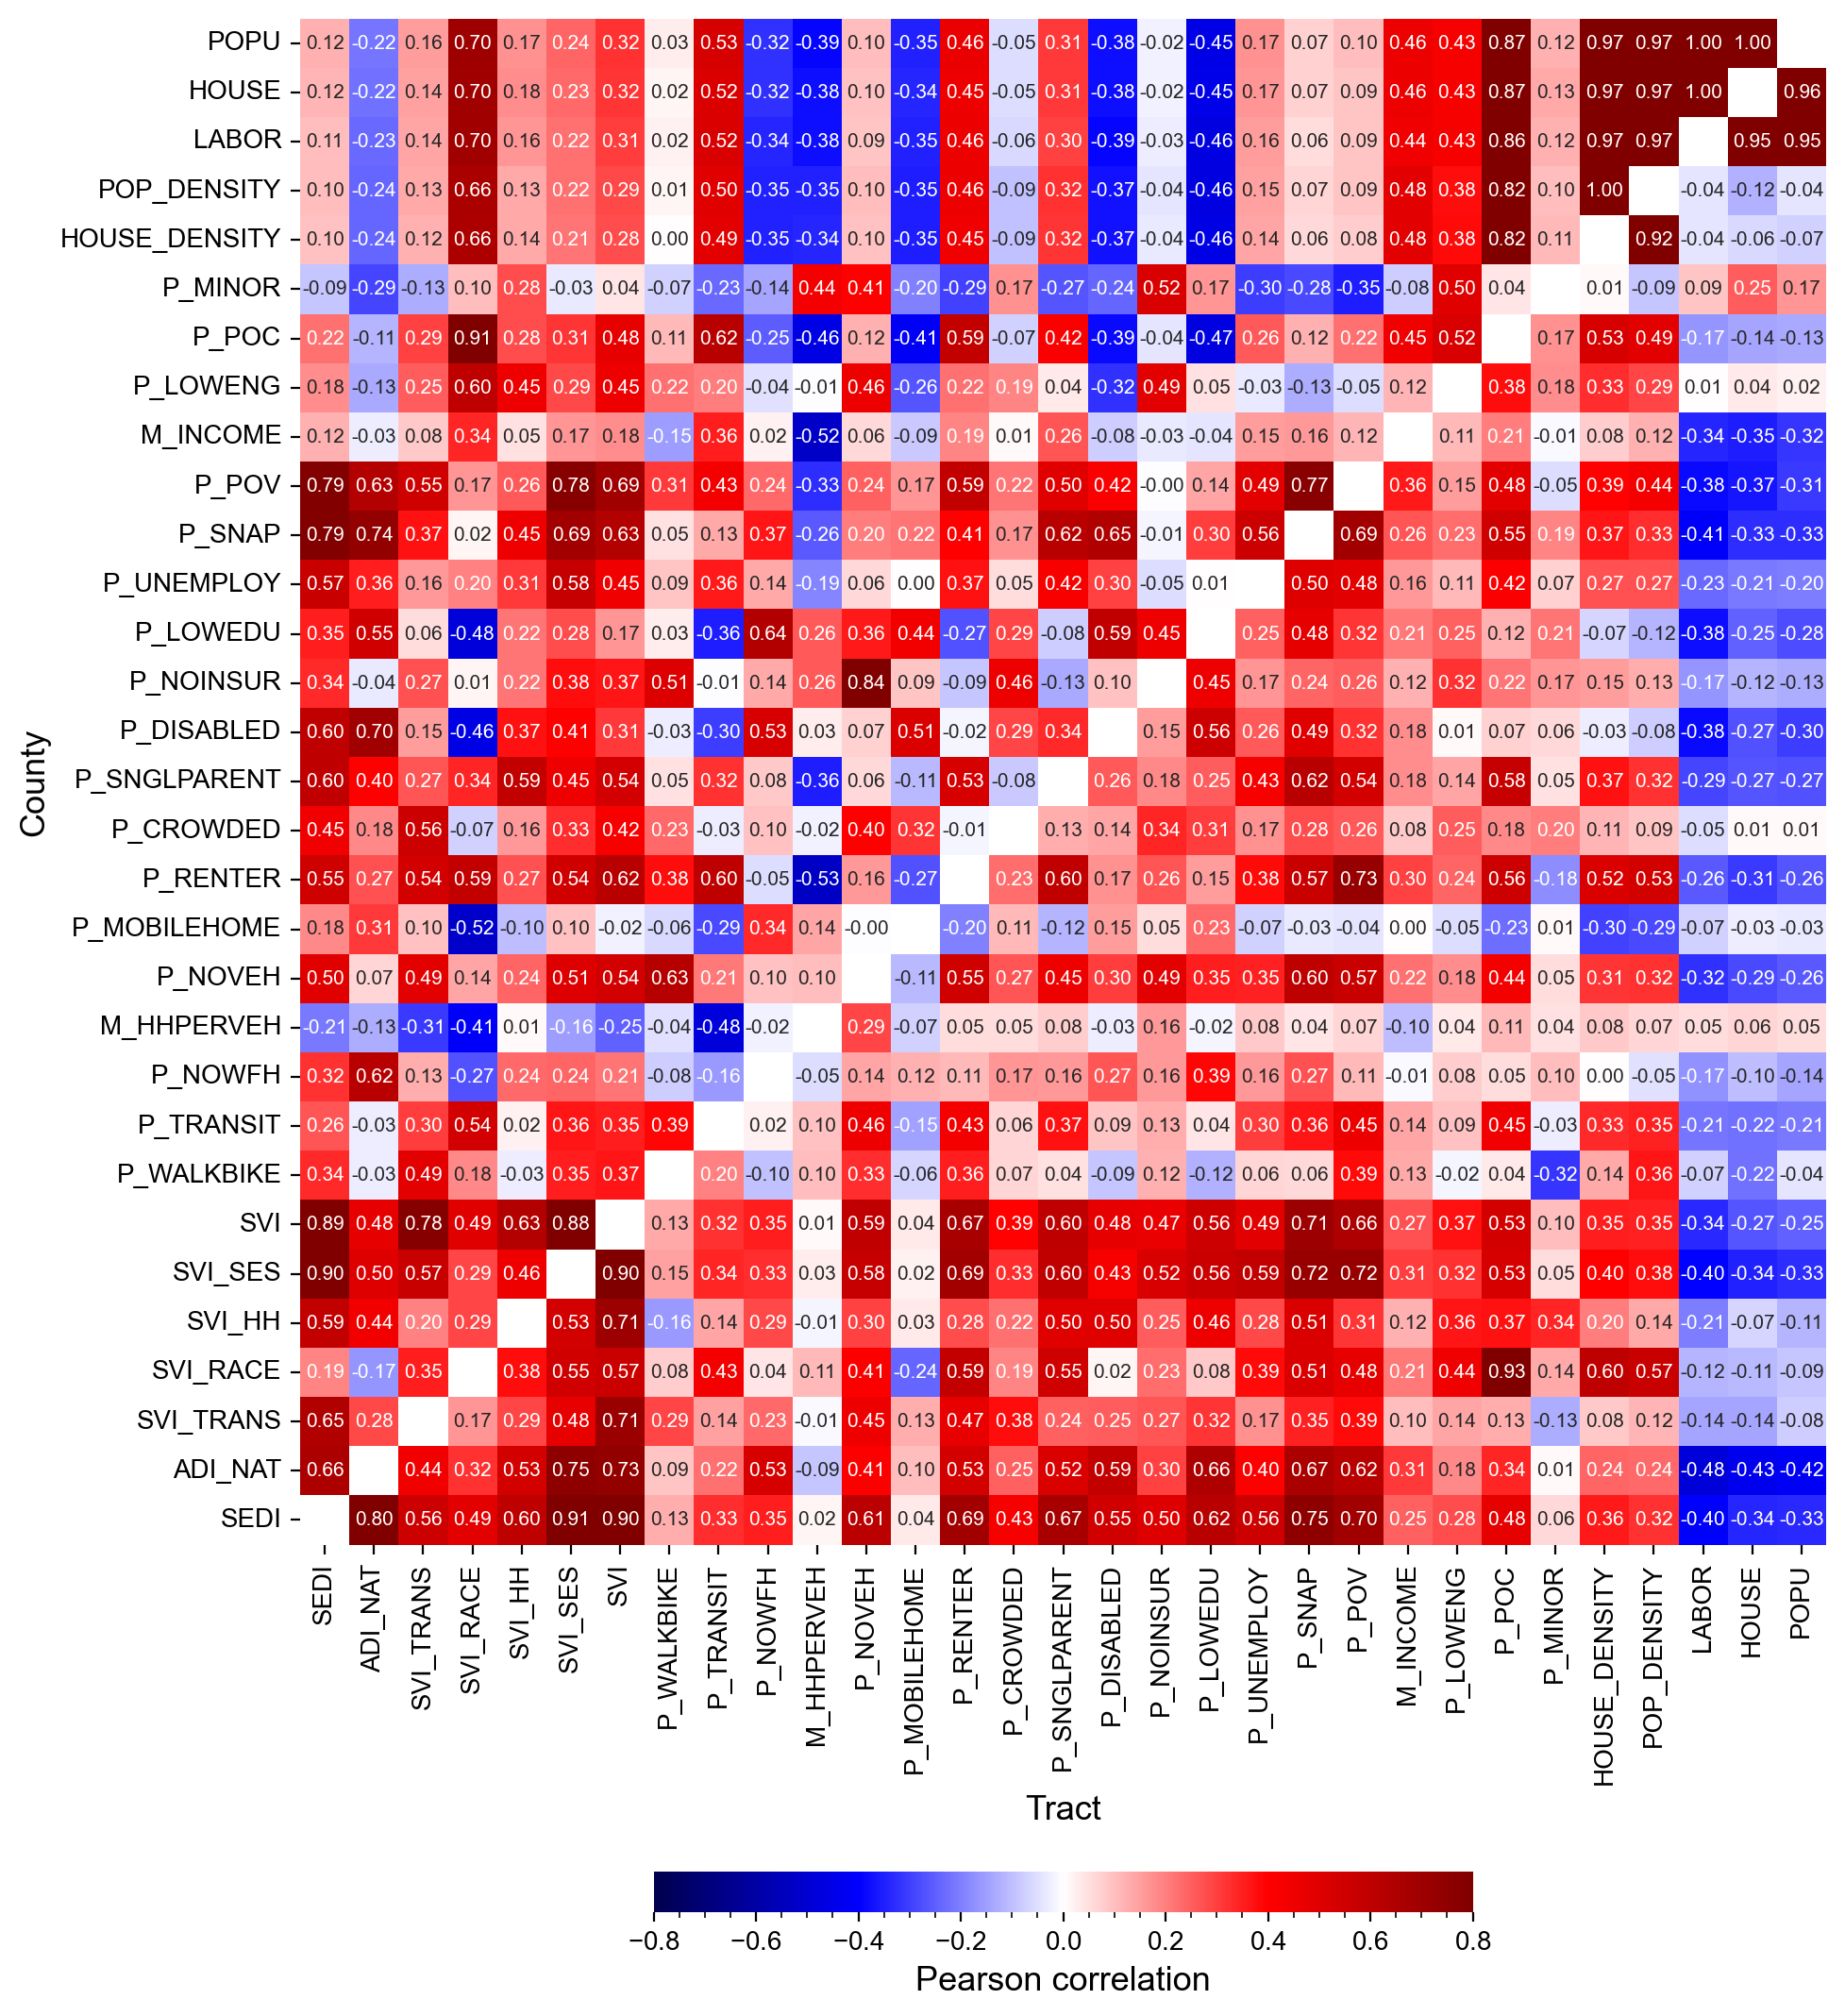

In [20]:
plot_corr_matrix(ses, '18') # 3s